# Define model constants

In [1]:
_HOLE_BOUND = ((-10, 10), (-10, 10))  # Hole boundary -10 <= x <= 10, -10 <= y <= 10

GRID_SCALE = 1
GRID_RESOLUTION = 2
GRID_W = 75
GRID_BOUND = ((-GRID_W / 2, GRID_W / 2), (-GRID_W / 2, GRID_W / 2))

# A. Define GPR model

In [2]:
from src.prediction.gpr_model_trainer import GPRModelTrainer

from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import numpy as np

gpr_kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

gpr_model_trainer = GPRModelTrainer(
    gpr_kernel=gpr_kernel,
    gpr_drag_config=(10, 1e-5),
    gpr_max_temp_config=(10, 1e-3),
    gpr_avg_temp_config=(10, 1e-3),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_W,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

----------------------------------------
| [ModelTrainer: ]: Model Trainer: GPR |
----------------------------------------


# B. Define RandomForest model

In [3]:
from src.prediction.rf_model_trainer import RfModelTrainer

rf_model_trainer = RfModelTrainer(
    rf_drag_config=(100, 42),
    rf_max_temp_config=(100, 42),
    rf_avg_temp_config=(100, 42),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_W,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

--------------------------------------------------
| [ModelTrainer: ]: Model Trainer: Random_Forest |
--------------------------------------------------


# C. Define ETR model

In [4]:
from src.prediction.etr_model_trainer import EtrModelTrainer

etr_model_trainer = EtrModelTrainer(
    etr_drag_config=(100, 42),
    etr_max_temp_config=(100, 42),
    etr_avg_temp_config=(100, 42),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_W,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

----------------------------------------
| [ModelTrainer: ]: Model Trainer: ETR |
----------------------------------------


# D. Define ENSEM model

In [5]:
from src.prediction.ensem_model_trainer import EnsemModelTrainer

ensem_model_trainer = EnsemModelTrainer(
    ensem_drag_config=(42, 10, 42),
    ensem_max_temp_config=(42, 10, 42),
    ensem_avg_temp_config=(42, 10, 42),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_W,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

------------------------------------------
| [ModelTrainer: ]: Model Trainer: ENSEM |
------------------------------------------


# E. Define ADA model

In [6]:
from src.prediction.ada_model_trainer import AdaModelTrainer

ada_model_trainer = AdaModelTrainer(
    ada_drag_config=(100, 42),
    ada_max_temp_config=(100, 42),
    ada_avg_temp_config=(100, 42),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_W,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

----------------------------------------
| [ModelTrainer: ]: Model Trainer: ADA |
----------------------------------------


# F. Define CRT model (Unstable)

In [7]:
from src.prediction.crt_model_trainer import CrtModelTrainer

crt_model_trainer = CrtModelTrainer(
    crt_drag_config=42,
    crt_avg_temp_config=42,
    crt_max_temp_config=42,
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_W,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.9,
)

----------------------------------------
| [ModelTrainer: ]: Model Trainer: CRT |
----------------------------------------


# Collect test models

In [8]:
from typing import Literal, Union
from src.prediction.model_trainer import ModelTrainer


test_models: list[tuple[ModelTrainer, Union[Literal["with_std", "without_std"]]]] = [
    (gpr_model_trainer, "with_std"),
    (rf_model_trainer, "without_std"),
    (etr_model_trainer, "without_std"),
    (ensem_model_trainer, "without_std"),
    (ada_model_trainer, "without_std"),
    # (crt_model_trainer, "without_std"),
]

# Test suite functions

1. with `std`: gaussian based regressions
    - `test_model_with_std__train_set`: test model with respect to original train input source.
    - `test_model_with_std__pattern`: test model with respect to new `list[Pattern]` data set. 
2. without `std`: basic regressions
    - `test_model_without_std__train_set`: test model with respect to original train input source.
    - `test_model_without_std__pattern`: test model with respect to new `list[Pattern]` data set. 

3. Benchmark all models

In [9]:
from src.geometry.pattern_unit import Pattern
from src.prediction.model_trainer import ModelTrainer
from src.prediction.to_model_input import to_model_input
from src.prediction.model_metrics import ModelMetrics


def test_model_with_std__train_set(model_trainer: ModelTrainer):
    res = model_trainer.get_train_set()
    model = model_trainer.get_model()

    if res is None:
        return

    x, y = res

    test = x[1:3]
    test_res = y[1:3]

    metrics = ModelMetrics(
        test_kit=test_res
        )

    drag, std1 = model[0].predict(test, return_std=True)
    met1 = metrics.drag_metrics(drag_pred=drag)       #metric : r^2
    avg_temp, std2 = model[1].predict(test, return_std=True)
    met2= metrics.ave_temp_metrics(ave_temp_pred=avg_temp)        #metric : MSE
    max_temp, std3 = model[2].predict(test, return_std=True)
    met3 = metrics.max_temp_metrics(max_temp_pred=max_temp)       #metric : MAE

    print("-" * 100)

    print(f">> {model_trainer.model_name} test for train_set input\n")
    print(">> real: [0.29223466, 372.84985, 452.61221]")
    print(">> predicted: ", drag, avg_temp, max_temp)
    print(">> std: ", std1, std2, std3)
    print(">> met: ", met1, met2, met3)

    print("-" * 100)


def test_model_without_std__train_set(model_trainer: ModelTrainer):
    model = model_trainer.get_model()
    res = model_trainer.get_train_set()

    if res is None:
        return

    x, y = res




    test = x[1:3]
    test_res = y[1:3]

    metrics = ModelMetrics(
        test_kit=test_res
        )
    
    drag = model[0].predict(test)
    met1 = metrics.drag_metrics(drag_pred=drag)       #metric : r^2
    avg_temp = model[1].predict(test)
    met2= metrics.ave_temp_metrics(ave_temp_pred=avg_temp)        #metric : MSE
    max_temp = model[2].predict(test)
    met3 = metrics.max_temp_metrics(max_temp_pred=max_temp)       #metric : MAE

    print("-" * 100)

    print(f">> {model_trainer.model_name} test for train_set input\n")
    print(">> real: ", test_res)
    print(">> predicted: ", drag, avg_temp, max_temp)
    print(">> met: ", met1, met2, met3)

    print("-" * 100)


def test_model_without_std__pattern(
    model_trainer: ModelTrainer, test_pattern: list[Pattern]
):
    print("-" * 100)

    print(f"Loading {model_trainer.model_name} model, pca...")
    model = model_trainer.get_model()
    pca = model_trainer.get_pca()

    print(f">> {model_trainer.model_name} test for train_set input\n")

    for i, pattern in enumerate(test_pattern):
        ins = to_model_input(
            pca,
            pattern_matrix=pattern.pattern_matrix,
            bound=GRID_BOUND,
            resolution=1 / GRID_RESOLUTION,
        )

        drag = model[0].predict(ins)
        avg_temp = model[1].predict(ins)
        max_temp = model[2].predict(ins)

        print(f">> test-{i} input prediction")
        print(f">> prediction: {drag}, {avg_temp}, {max_temp}")

    print("-" * 100)


def test_model_with_std__pattern(
    model_trainer: ModelTrainer, test_pattern: list[Pattern]
):
    print("-" * 100)
    print(f"Loading {model_trainer.model_name} model, pca...")
    model = model_trainer.get_model()
    pca = model_trainer.get_pca()

    print(f">> {model_trainer.model_name} test for train_set input\n")

    for i, pattern in enumerate(test_pattern):
        ins = to_model_input(
            pca,
            pattern_matrix=pattern.pattern_matrix,
            bound=GRID_BOUND,
            resolution=1 / GRID_RESOLUTION,
        )

        drag, std = model[0].predict(ins, return_std=True)
        avg_temp, std2 = model[1].predict(ins, return_std=True)
        max_temp, std3 = model[2].predict(ins, return_std=True)

        print(f">> test-{i} input prediction")
        print(f">> prediction: {drag}, std: {std}")
        print(f">> prediction: {avg_temp}, std: {std2}")
        print(f">> prediction: {max_temp}, std: {std3}")

    print("-" * 100)


def bench_all_models(
    models: list[tuple[ModelTrainer, Union[Literal["with_std", "without_std"]]]],
    test_pattern: list[Pattern],
):
    for model, std in models:
        if std == "with_std":
            test_model_with_std__train_set(model)
            test_model_with_std__pattern(model, test_pattern)
        else:
            test_model_without_std__train_set(model)
            test_model_without_std__pattern(model, test_pattern)

# Generate test input data

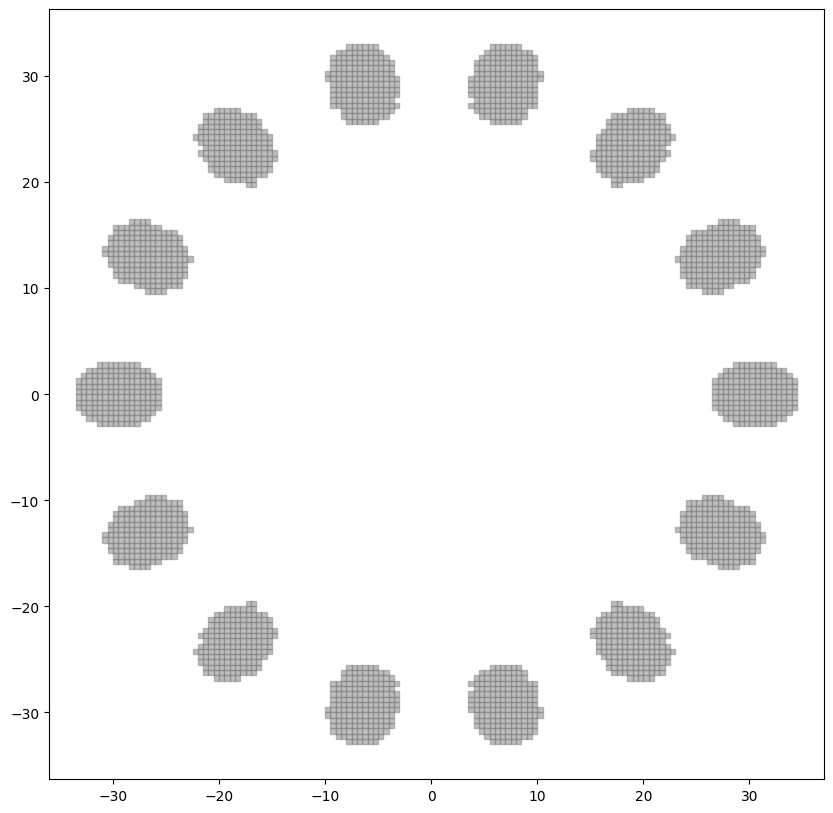

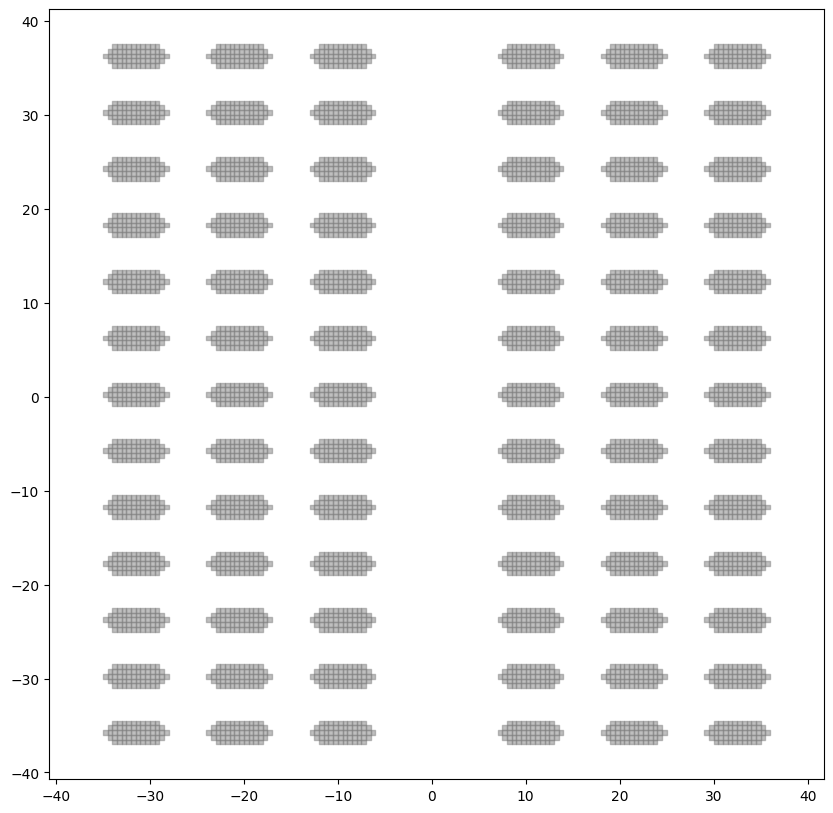

In [10]:
from src.grid.visualize_points import visualize_points
from src.geometry.pattern_unit import (
    PatternUnit,
    Shape,
    PatternTransformation,
    PatternTransformationMatrix,
    Pattern,
)

pattern1 = Pattern(
    pattern_transformation_matrix=PatternTransformationMatrix(
        pattern_unit=PatternUnit(
            Shape(
                w=10,
                h=7.5,
                area_functions=[lambda x, y: x**2 / 16 + y**2 / 9 <= 1],
            ),
            k=1 / GRID_RESOLUTION,
        ),
        pattern_transformation=PatternTransformation(
            "circular",
            dx=2.5,
            di=25,
            phi=np.pi / 7,
        ),
        pattern_bound=GRID_BOUND,
    ),
)

visualize_points(
    pattern1.pattern_matrix,
    k=1 / GRID_RESOLUTION,
)

pattern2 = Pattern(
    pattern_transformation_matrix=PatternTransformationMatrix(
        pattern_unit=PatternUnit(
            Shape(
                w=10,
                h=5,
                area_functions=[lambda x, y: x**2 / 9 + y**2 / 2 <= 1],
            ),
            k=1 / GRID_RESOLUTION,
        ),
        pattern_transformation=PatternTransformation(
            "grid",
            dx=10,
            di=10 / 2,
        ),
        pattern_bound=GRID_BOUND,
    ),
)
visualize_points(
    pattern2.pattern_matrix,
    k=1 / GRID_RESOLUTION,
)

# Run tests

In [11]:
bench_all_models(test_models, [pattern1, pattern2])

-------------------------------------------------
| [ModelTrainer: ]: Training set found, loading |
-------------------------------------------------
-------------------------------------------------
| [ModelTrainer: ]: Training set found, loading |
-------------------------------------------------


C:\Users\eaton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\eaton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\eaton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning:

----------------------------------------------------------------------------------------------------
>> gpr test for train_set input

>> real: [0.29223466, 372.84985, 452.61221]
>> predicted:  [0.2923495  0.29273559] [372.84898235 370.88567422] [452.61196569 445.03630726]
>> std:  [0.00213808 0.00127747] [0.03162023 0.03160561] [0.03162219 0.03161966]
>> met:  -3.3666369188825556 1.6979866835796803e-06 0.0010157876875211969
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Loading gpr model, pca...
-------------------------------------------------
| [ModelTrainer: ]: Training set found, loading |
-------------------------------------------------
------------------------------------------------------
| [ModelTrainer: ]: PCA optimal founding initialized |
------------------------------------------------------
-----------------------------

## GPR prev result tests

### A1. `(-30, 30), res: 3`
```bash
(1, 106)
(1, 106)
>> ins1 prediction
>> prediction: [0.29497703], std: [0.00218427]
>> prediction: [392.91214535], std: [0.95447247]
>> prediction: [518.54214407], std: [2.37395765]
>> ins2 prediction
>> prediction: [0.29466794], std: [0.00233069]
>> prediction: [390.18615569], std: [1.01531236]
>> prediction: [504.76525881], std: [2.51555504]
```

### A2. `(-30, 30), res: 2`
```bash
(1, 107)
(1, 107)
>> ins1 prediction
>> prediction: [0.29583199], std: [0.00382364]
>> prediction: [383.75400754], std: [0.84201941]
>> prediction: [498.071324], std: [2.23880663]
>> ins2 prediction
>> prediction: [0.29814156], std: [0.00481413]
>> prediction: [390.5626691], std: [1.08056385]
>> prediction: [516.80923951], std: [2.82949011]
```

### B1. `(-50, 50), res: 2`
```bash
(1, 107)
(1, 107)
>> ins1 prediction
>> prediction: [0.29855318], std: [0.00413844]
>> prediction: [395.1396864], std: [0.9193178]
>> prediction: [531.81106611], std: [2.43499191]
>> ins2 prediction
>> prediction: [0.29737008], std: [0.00495669]
>> prediction: [393.6109499], std: [1.11294301]
>> prediction: [525.46977552], std: [2.90263788]
```